In [1]:
import pandas as pd

In [2]:
import chardet

with open("../data/Frankenstein_Plan_Mengen_ZR.csv", "rb") as f:
    result = chardet.detect(f.read(100000))
    print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [9]:
import pandas as pd

# Schritt 1: CSV einlesen
df_raw = pd.read_csv(
    "../data/Frankenstein_Plan_Mengen_ZR.csv",
    encoding="ISO-8859-1",
    sep=";",
    header=None,
    skip_blank_lines=False,
    low_memory=False
)

# Schritt 2: Hole Zeitreihen-Namen (Zeile 10 -> index 9) & Spaltenüberschriften (Zeile 17 -> index 16)
reihe_names = df_raw.iloc[9].tolist()
reihe_names[0] = "von"
reihe_names[1] = "bis"
einheiten = df_raw.iloc[16].tolist()

# Schritt 3: Erstelle MultiIndex für die Spalten
multi_cols = pd.MultiIndex.from_arrays([einheiten, reihe_names])

# Schritt 4: Daten ab Zeile 18 (index 17)
df = df_raw.iloc[17:].copy()
df.columns = multi_cols
df.reset_index(drop=True, inplace=True)

# Schritt 5: MultiIndex zu sprechenden Spaltennamen zusammenführen
df.columns = [f"{unit} | {name}" for unit, name in df.columns]


von_raw = df['von  | von']
bis_raw = df['bis | bis']

# Schritt 6: Konvertiere alle "object"-Spalten mit deutschem Zahlenformat zu float
df = df.apply(lambda col: col.str.replace(" ", "").str.replace(",", ".") if col.dtype == "object" else col)
df = df.apply(pd.to_numeric, errors="ignore")

df

C:\Users\johan\AppData\Local\Temp\ipykernel_28872\944154045.py:36: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


,von | von,bis | bis,MWh/h | FL_00024360.PLAN.MengeHH.2,MWh/h | FL_00024360.PLAN.MengeHH.1,MWh/h | FL_00024360.PLAN.MengeKW,MWh/h | FL_00024360.PLAN.MengeGA,MWh/h | FL_00352230.PLAN.MengeGA,MWh/h | FL_00025289.PLAN.MengeGA,MWh/h | FL_00025287.PLAN.MengeGA,MWh/h | FL_00025297.PLAN.MengeGA,...,MWh/h | CV_00349016.PLAN.Menge,MWh/h | CV_00349013.PLAN.Menge,MWh/h | CV_00349005.PLAN.Menge,MWh/h | CV_00349004.PLAN.Menge,MWh/h | CV_00349002.PLAN.Menge,MWh/h | CV_00348857.PLAN.Menge,MWh/h | KN_00005030.PLAN.Menge.2,MWh/h | KN_00005030.PLAN.Menge.1,MWh/h | KN_00005023.PLAN.Menge.2,MWh/h | KN_00005023.PLAN.Menge.1
0,01.01.201406:00,01.01.201407:00,51.476,1709.224,461.161,1025.914,45.360,28.190,57.864,121.684,...,NaN,NaN,NaN,0.753,34.045,NaN,19.550,1.079,7.284,1.900
1,01.01.201407:00,01.01.201408:00,51.026,1671.588,453.456,1022.869,42.560,28.224,57.765,117.911,...,NaN,NaN,NaN,0.607,35.279,NaN,18.923,0.955,6.890,1.562
2,01.01.201408:00,01.01.201409:00,50.688,1817.313,454.455,1027.474,64.546,27.976,60.100,120.903,...,NaN,NaN,NaN,0.573,32.063,NaN,18.832,0.865,6.396,1.664
3,01.01.201409:00,01.01.201410:00,50.857,1725.431,455.622,1022.988,72.453,28.134,60.483,120.126,...,NaN,NaN,NaN,0.495,28.629,NaN,18.636,0.865,6.890,1.619
4,01.01.201410:00,01.01.201411:00,50.873,1997.502,454.479,1024.464,69.048,27.853,60.366,120.459,...,NaN,NaN,NaN,0.562,28.563,NaN,18.158,0.787,8.497,1.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,01.01.202201:00,01.01.202202:00,0.000,862.281,25.255,258.222,31.612,33.446,37.185,164.931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70124,01.01.202202:00,01.01.202203:00,0.000,789.112,27.725,253.316,35.805,33.605,38.159,165.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70125,01.01.202203:00,01.01.202204:00,0.000,791.423,28.767,245.283,33.190,33.616,39.938,155.266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70126,01.01.202204:00,01.01.202205:00,0.000,834.285,30.138,243.504,32.739,33.401,39.859,151.845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
von = df[("von  | von")]
bis = df["bis | bis"]

von = pd.to_datetime(von_raw, dayfirst=True, errors="coerce")
bis = pd.to_datetime(bis_raw, dayfirst=True, errors="coerce")

df.index = von

df = df.drop(columns=[("von  | von"), ("bis | bis")])

df.head()

KeyError: 'von  | von'

In [12]:
import re
import pandas as pd
from collections import defaultdict

# --- 1) Index sauber setzen: Name + Typ + Frequenz ---
# Falls noch kein DatetimeIndex:
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce")

# Du wolltest einen markanten Namen:
df.index.name = "Zeitstempel_UTC"

# # Sicherstellen, dass stündliche Frequenz abgebildet wird (füllt evtl. Lücken mit NaN):
# df = df.sort_index().asfreq("h")

# --- 2) Spaltennamen aufräumen (Anführungszeichen/Whitespaces entfernen) ---
def clean_col(col: str) -> str:
    col = str(col).strip()
    # umschließende Quotes entfernen
    if (col.startswith('"') and col.endswith('"')) or (col.startswith("'") and col.endswith("'")):
        col = col[1:-1]
    return col.strip()

df = df.rename(columns={c: clean_col(c) for c in df.columns})

# --- 3) Regex, um Präfix (FL/CV/KN) und "Menge"-Suffix zu greifen ---
# Beispiele, die wir abdecken:
# "MWh/h | FL_00024360.PLAN.MengeHH.2"
# "kNm³/h | FL_00342878.PLAN.Menge.1"
# "MWh/h | CV_00003435.PLAN.Menge.2"
# "MWh/h | KN_00005140.PLAN.MengeKW"
pat = re.compile(
    r"""^[^|]*\|\s*              # Einheit und '|'
        (?P<prefix>(FL|CV|KN))_  # Präfix-Gruppe
        \d+\.PLAN\.              # Nummer + '.PLAN.'
        (?P<mengesuf>            # Menge-Suffix:
           Menge(?:HH|KW|GA)?    # 'Menge' optional mit HH/KW/GA
        )
        (?:\.\d+)?$              # optionaler .1/.2 Suffix
    """,
    re.X
)

# Mapping 'Menge' -> 'Mengen' gemäß deinem Beispiel
def to_mengen_label(mengesuf: str) -> str:
    # Menge, MengeHH, MengeKW, MengeGA -> Mengen, MengenHH, MengenKW, MengenGA
    return mengesuf.replace("Menge", "Mengen", 1)

# --- 4) Zähler je Präfix und eindeutige Namen erzeugen ---
counters = defaultdict(int)
new_names = {}
seen = set()

for col in df.columns:
    m = pat.match(col)
    if m:
        prefix = m.group("prefix")  # FL, CV, KN
        mengesuf = to_mengen_label(m.group("mengesuf"))
        counters[prefix] += 1
        base_name = f"{prefix}_Zeitreihe_{counters[prefix]}_{mengesuf}"
    else:
        # Fallback für nicht passende Spalten: neutral "X"
        counters["X"] += 1
        base_name = f"X_Zeitreihe_{counters['X']}_Mengen"

    # Kollisionen (zur Sicherheit) mit Suffix __dup2, __dup3 ...
    name = base_name
    k = 2
    while name in seen:
        name = f"{base_name}__dup{k}"
        k += 1
    seen.add(name)
    new_names[col] = name

# --- 5) Umbenennen anwenden ---
df = df.rename(columns=new_names)

# --- 6) (Optional) Mapping als DataFrame speichern/anzeigen ---
mapping_df = pd.DataFrame(
    [(old, new) for old, new in new_names.items()],
    columns=["original_col", "anonymized_col"]
).sort_values("anonymized_col")

# Optional: ins Filesystem schreiben
# mapping_df.to_csv("spaltenmapping_anonymisiert.csv", index=False)

# Zur Kontrolle: ein paar Beispiele



,original_col,anonymized_col
290,MWh/h | CV_00007888.PLAN.Menge,CV_Zeitreihe_100_Mengen
291,MWh/h | CV_00006130.PLAN.Menge.4,CV_Zeitreihe_101_Mengen
292,MWh/h | CV_00006130.PLAN.Menge.3,CV_Zeitreihe_102_Mengen
293,MWh/h | CV_00006130.PLAN.Menge.2,CV_Zeitreihe_103_Mengen
294,MWh/h | CV_00006130.PLAN.Menge.1,CV_Zeitreihe_104_Mengen
295,MWh/h | CV_00349012.PLAN.Menge.2,CV_Zeitreihe_105_Mengen
296,MWh/h | CV_00349012.PLAN.Menge.1,CV_Zeitreihe_106_Mengen
297,MWh/h | CV_00005156.PLAN.Menge.3,CV_Zeitreihe_107_Mengen
298,MWh/h | CV_00005156.PLAN.Menge.2,CV_Zeitreihe_108_Mengen
299,MWh/h | CV_00005156.PLAN.Menge.1,CV_Zeitreihe_109_Mengen


In [14]:
mapping_df

,original_col,anonymized_col
290,MWh/h | CV_00007888.PLAN.Menge,CV_Zeitreihe_100_Mengen
291,MWh/h | CV_00006130.PLAN.Menge.4,CV_Zeitreihe_101_Mengen
292,MWh/h | CV_00006130.PLAN.Menge.3,CV_Zeitreihe_102_Mengen
293,MWh/h | CV_00006130.PLAN.Menge.2,CV_Zeitreihe_103_Mengen
294,MWh/h | CV_00006130.PLAN.Menge.1,CV_Zeitreihe_104_Mengen
...,...,...
274,MWh/h | KN_00002963.PLAN.MengeGA,KN_Zeitreihe_96_MengenGA
275,MWh/h | KN_00003370.PLAN.MengeKW,KN_Zeitreihe_97_MengenKW
276,MWh/h | KN_00003363.PLAN.MengeKW,KN_Zeitreihe_98_MengenKW
277,MWh/h | KN_00001613.PLAN.MengeGA,KN_Zeitreihe_99_MengenGA


In [15]:
df

,FL_Zeitreihe_1_MengenHH,FL_Zeitreihe_2_MengenHH,FL_Zeitreihe_3_MengenKW,FL_Zeitreihe_4_MengenGA,FL_Zeitreihe_5_MengenGA,FL_Zeitreihe_6_MengenGA,FL_Zeitreihe_7_MengenGA,FL_Zeitreihe_8_MengenGA,FL_Zeitreihe_9_MengenKW,FL_Zeitreihe_10_MengenGA,...,CV_Zeitreihe_122_Mengen,CV_Zeitreihe_123_Mengen,CV_Zeitreihe_124_Mengen,CV_Zeitreihe_125_Mengen,CV_Zeitreihe_126_Mengen,CV_Zeitreihe_127_Mengen,KN_Zeitreihe_108_Mengen,KN_Zeitreihe_109_Mengen,KN_Zeitreihe_110_Mengen,KN_Zeitreihe_111_Mengen
Zeitstempel_UTC,,,,,,,,,,,,,,,,,,,,,
2014-01-01 06:00:00,51.476,1709.224,461.161,1025.914,45.360,28.190,57.864,121.684,0.000,72.563,...,NaN,NaN,NaN,0.753,34.045,NaN,19.550,1.079,7.284,1.900
2014-01-01 07:00:00,51.026,1671.588,453.456,1022.869,42.560,28.224,57.765,117.911,0.000,76.735,...,NaN,NaN,NaN,0.607,35.279,NaN,18.923,0.955,6.890,1.562
2014-01-01 08:00:00,50.688,1817.313,454.455,1027.474,64.546,27.976,60.100,120.903,0.000,67.399,...,NaN,NaN,NaN,0.573,32.063,NaN,18.832,0.865,6.396,1.664
2014-01-01 09:00:00,50.857,1725.431,455.622,1022.988,72.453,28.134,60.483,120.126,0.000,65.328,...,NaN,NaN,NaN,0.495,28.629,NaN,18.636,0.865,6.890,1.619
2014-01-01 10:00:00,50.873,1997.502,454.479,1024.464,69.048,27.853,60.366,120.459,0.000,59.546,...,NaN,NaN,NaN,0.562,28.563,NaN,18.158,0.787,8.497,1.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 01:00:00,0.000,862.281,25.255,258.222,31.612,33.446,37.185,164.931,6.775,216.890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 02:00:00,0.000,789.112,27.725,253.316,35.805,33.605,38.159,165.078,8.112,196.111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 03:00:00,0.000,791.423,28.767,245.283,33.190,33.616,39.938,155.266,6.050,188.599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


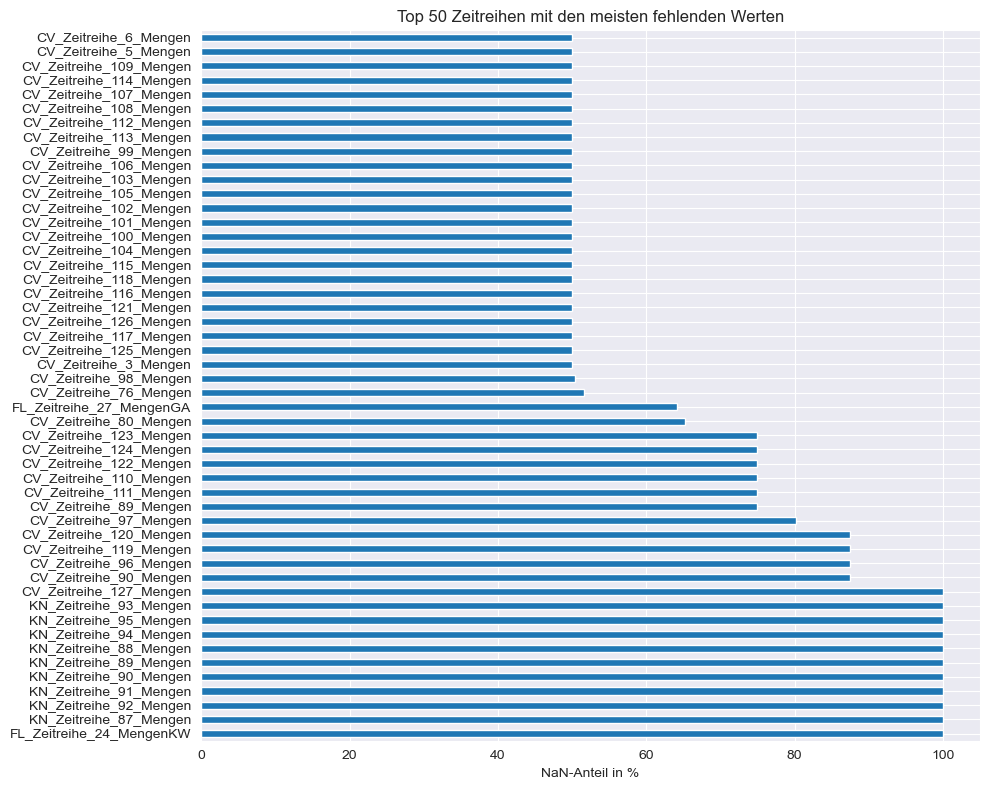

In [24]:
import matplotlib.pyplot as plt

na_share = df.isna().mean() * 100
na_share_filtered = na_share[na_share > 0].sort_values()


top_missing = na_share.sort_values(ascending=False).head(50)

top_missing.plot(
    kind="barh",
    figsize=(10, 8),
    title="Top 50 Zeitreihen mit den meisten fehlenden Werten"
)
plt.xlabel("NaN-Anteil in %")
plt.tight_layout()
plt.show()

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [18]:
inventory

,start,end,n_obs,n_valid,coverage_%,nan_%,zeros_%,negatives_%,mean,std,min,q1,median,q3,max
KN_Zeitreihe_101_MengenKW,2014-01-01 06:00:00,2022-01-01 05:00:00,70128.0,70128.0,100.0,0.0,19.484371,0.0,138.637993,160.491985,0.0,11.36575,48.1820,240.01775,628.577
KN_Zeitreihe_99_MengenGA,2014-01-01 06:00:00,2022-01-01 05:00:00,70128.0,70128.0,100.0,0.0,0.034223,0.0,619.404166,141.882075,0.0,587.28050,687.3940,706.04700,779.362
KN_Zeitreihe_100_MengenKW,2014-01-01 06:00:00,2022-01-01 05:00:00,70128.0,70128.0,100.0,0.0,28.295403,0.0,84.903157,92.204348,0.0,0.00000,87.7315,135.13025,426.779
FL_Zeitreihe_22_MengenGA,2014-01-01 06:00:00,2022-01-01 05:00:00,70128.0,70128.0,100.0,0.0,0.027093,0.0,145.385502,15.708360,0.0,135.63100,146.3460,155.70800,205.934
FL_Zeitreihe_31_MengenHH,2014-01-01 06:00:00,2022-01-01 05:00:00,70128.0,70128.0,100.0,0.0,0.132615,0.0,17.528967,7.990996,0.0,10.54900,15.8095,23.34600,51.279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KN_Zeitreihe_92_Mengen,NaT,NaT,70128.0,0.0,0.0,100.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KN_Zeitreihe_88_Mengen,NaT,NaT,70128.0,0.0,0.0,100.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KN_Zeitreihe_89_Mengen,NaT,NaT,70128.0,0.0,0.0,100.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KN_Zeitreihe_90_Mengen,NaT,NaT,70128.0,0.0,0.0,100.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.index.max()

Timestamp('2022-01-01 05:00:00')